## 📊 Projeto – Random Forest

Uma empresa de tecnologia tem buscado formas de reter seus funcionários, dado o aumento no turnover nos últimos anos, fruto de uma profusão de empresas da nova economia, que têm feito ofertas tentadoras para roubar talentos, com desafios e remunerações mais atrativos.

**Mas a pergunta é:**  
Será que somente um novo desafio ou um salário melhor é que estão motivando as pessoas a saírem desta empresa?

Com o objetivo de responder esta pergunta e propor mudanças drásticas na Diretoria de Pessoas, com o intuito de prevenir a evasão de talentos com medidas personalizadas de retenção, o time de ciência de dados irá tratar num modelo capaz de prever a **probabilidade de churn** de um funcionário, mas também avaliar as **principais motivações** para este churn.

📁 Para isso, contará com um dataset histórico com dados de funcionários, contendo dados demográficos, dados sobre a relação do funcionário com a empresa e a variável target que indica se o funcionário saiu ou não da companhia.

🧠 E dada a complexidade do desafio e a quantidade de variáveis envolvidas, iremos usar o ensemble **Random Forest** para fazer esta predição da variável target, da probabilidade do funcionário sair e as possíveis razões pra isso.

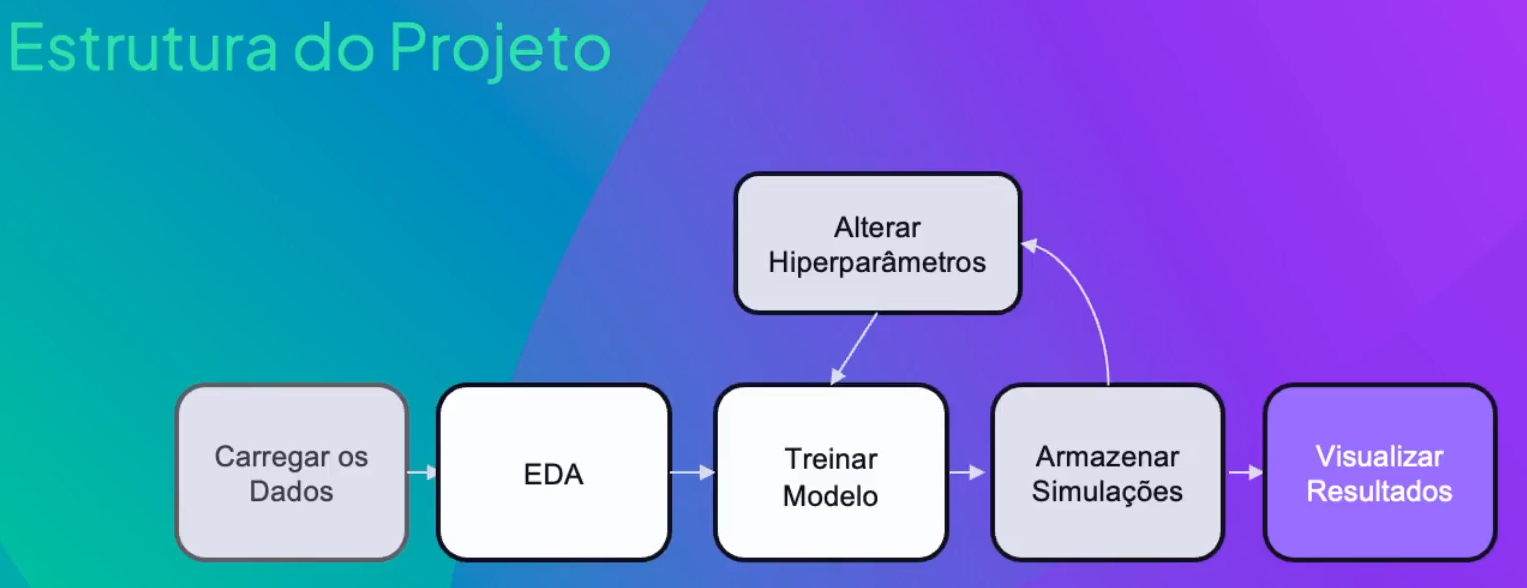

In [72]:
# Importar as bibliotecas

# EDA
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Visualizações
import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import shap

# Para preparação dos dados
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, \
    ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, \
    f1_score, precision_score, recall_score

# Otimização de Hiperparâmetros
import optuna

### Carregar os dados

In [2]:
# Carregar o dataset
df_employees = pd.read_csv('./datasets/employee_churn_dataset.csv',
                           parse_dates=['data_contratacao', 'data_demissao', 'data_ultimo_feedback', 
                                        'data_ultimo_aumento','data_ultima_mudanca_cargo'],
                           date_format='%Y-%m-%d')

In [3]:
# Visualizar estrutura do dataset
df_employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2000 non-null   object        
 1   idade                      2000 non-null   int64         
 2   genero                     2000 non-null   object        
 3   estado_civil               2000 non-null   object        
 4   educacao                   2000 non-null   object        
 5   regime_trabalho            2000 non-null   object        
 6   data_contratacao           2000 non-null   datetime64[ns]
 7   data_demissao              286 non-null    datetime64[ns]
 8   tipo_demissao              286 non-null    object        
 9   cargo                      2000 non-null   object        
 10  salario_atual              2000 non-null   int64         
 11  data_ultimo_feedback       2000 non-null   datetime64[ns]
 12  data_u

In [4]:
# Visualizar primeiros registros
df_employees.head(20)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0
5,EMP1053,49,Outro,Casado(a),Technical Degree,Híbrido,2020-01-08,NaT,NaN,Junior Developer,6507,2022-06-01,2020-07-05,2021-09-02,7.9,True,8,4,7.1,0
6,EMP1152,29,M,Casado(a),PhD,Presencial,2020-01-10,2022-08-22,Involuntária,Product Manager,12575,2020-10-16,2020-08-11,2022-02-27,9.1,True,6,3,1.9,1
7,EMP1317,38,F,Viúvo(a),PhD,Remoto,2020-01-11,NaT,NaN,DevOps Engineer,16643,2023-03-28,2023-05-16,2022-03-28,8.9,False,6,4,8.3,0
8,EMP1398,33,M,Casado(a),Technical Degree,Remoto,2020-01-12,NaT,NaN,DevOps Engineer,16771,2024-01-03,2024-03-13,2024-06-15,7.6,False,8,1,1.2,0
9,EMP0167,23,M,Viúvo(a),PhD,Híbrido,2020-01-13,NaT,NaN,QA Engineer,13258,2022-01-02,2021-09-15,2024-04-04,8.1,True,3,6,7.0,0


In [5]:
# Visualizar ultimos registros
df_employees.tail(20)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
1980,EMP1745,40,M,Casado(a),Technical Degree,Presencial,2024-07-08,NaT,NaN,UX Designer,6751,2024-09-27,2024-08-04,2024-07-09,6.5,False,5,4,1.3,0
1981,EMP0323,46,Outro,Divorciado(a),Technical Degree,Híbrido,2024-07-09,NaT,NaN,Tech Lead,7962,2024-08-15,2024-10-12,2024-08-21,8.4,True,9,1,3.2,0
1982,EMP0047,26,M,Solteiro(a),Master,Presencial,2024-07-10,NaT,NaN,Data Scientist,22749,2024-08-18,2024-08-09,2024-07-17,9.3,True,7,1,6.3,0
1983,EMP0063,24,Outro,Divorciado(a),Bachelor,Remoto,2024-07-11,NaT,NaN,Tech Lead,17891,2024-09-01,2024-08-04,2024-07-23,7.4,False,5,6,2.1,0
1984,EMP1864,46,M,Casado(a),Technical Degree,Presencial,2024-07-12,NaT,NaN,Senior Developer,10274,2024-08-03,2024-08-14,2024-10-20,6.1,True,6,1,7.6,0
1985,EMP1333,39,Outro,Divorciado(a),Bachelor,Remoto,2024-07-12,2024-09-20,Voluntária,Tech Lead,11728,2024-09-04,2024-08-02,2024-07-12,9.9,True,8,1,9.6,1
1986,EMP0071,24,Outro,Divorciado(a),Technical Degree,Híbrido,2024-07-12,2024-10-20,Voluntária,UX Designer,13659,2024-07-24,2024-07-18,2024-10-03,9.9,False,6,6,3.3,1
1987,EMP1740,39,M,Casado(a),Master,Híbrido,2024-07-12,NaT,NaN,Tech Lead,20329,2024-08-04,2024-09-28,2024-08-10,6.8,True,3,1,7.5,0
1988,EMP1858,44,M,Casado(a),Technical Degree,Híbrido,2024-07-14,NaT,NaN,Tech Lead,20987,2024-10-16,2024-10-01,2024-07-17,9.7,False,8,7,9.5,0
1989,EMP0688,26,F,Solteiro(a),PhD,Híbrido,2024-07-15,NaT,NaN,QA Engineer,9846,2024-10-07,2024-09-06,2024-10-01,8.5,True,3,7,2.1,0


### Engenharia de Features

In [6]:
# Criar features baseadas em datas (diferença em dias)

# Calcular tempo de empresa
df_employees['tempo_empresa'] = df_employees.apply(lambda x:
    (pd.Timestamp.now() - x['data_contratacao']).days if x['churn'] == 0
    else (x['data_demissao'] - x['data_contratacao']).days, axis=1)

# Calcular tempo desde o ultimo feedback
df_employees['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employees['data_ultimo_feedback']).dt.days

# Calcular tempo desde o ultimo aumento
df_employees['dias_desde_ultimo_aumento'] = (pd.Timestamp.now() - df_employees['data_ultimo_aumento']).dt.days

# Calcular tempo desde a ultima mudanca de cargo
df_employees['dias_desde_ultima_mudanca_cargo'] = (pd.Timestamp.now() - df_employees['data_ultima_mudanca_cargo']).dt.days

In [7]:
# Remover Id
df_employees.drop(columns=['id'], axis=1, inplace=True)

### EDA

In [8]:
# Verificacao de valores ausentes
print('Valores ausentes por coluna')
df_employees.isnull().sum()

Valores ausentes por coluna


idade                                 0
genero                                0
estado_civil                          0
educacao                              0
regime_trabalho                       0
data_contratacao                      0
data_demissao                      1714
tipo_demissao                      1714
cargo                                 0
salario_atual                         0
data_ultimo_feedback                  0
data_ultimo_aumento                   0
data_ultima_mudanca_cargo             0
nota_avaliacao                        0
acompanhamento_psicologo              0
qtde_projetos                         0
qtde_clientes                         0
nivel_satisfacao_gestor               0
churn                                 0
tempo_empresa                         0
dias_desde_ultimo_feedback            0
dias_desde_ultimo_aumento             0
dias_desde_ultima_mudanca_cargo       0
dtype: int64

In [9]:
# Distribuicao da variavel target em percentual

fig = px.bar(df_employees['churn'].value_counts() / len(df_employees) * 100,
             title='Fator de Churn',
             labels={'index': 'Churn', 'value': 'Percentual'},
             opacity=0.8
             )

fig.update_layout(showlegend=False)
fig.show()

In [10]:
# Valores possiveis para variaveis categoricas
for col in df_employees.select_dtypes(include=['object']).columns:
    print(f'\nValores únicos em {col}:')
    print(df_employees[col].unique())


Valores únicos em genero:
['F' 'Outro' 'M']

Valores únicos em estado_civil:
['Divorciado(a)' 'Viúvo(a)' 'Casado(a)' 'Solteiro(a)']

Valores únicos em educacao:
['Master' 'Technical Degree' 'Bachelor' 'PhD']

Valores únicos em regime_trabalho:
['Remoto' 'Híbrido' 'Presencial']

Valores únicos em tipo_demissao:
[nan 'Involuntária' 'Voluntária']

Valores únicos em cargo:
['Senior Developer' 'UX Designer' 'Tech Lead' 'QA Engineer'
 'Junior Developer' 'Product Manager' 'DevOps Engineer' 'Data Scientist']


In [11]:
# Estatisticas descritivas das variaveis numericas
df_employees.select_dtypes(include=['int64', 'float64']).describe()
    

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000,2000.000000
mean,37.938500,14801.834500,7.997550,4.984500,3.998500,5.492450,0.14300,1031.662000,687.89900,701.005000,688.136500
std,9.456132,5763.451836,1.157324,2.593188,1.987076,2.609817,0.35016,513.650834,395.59628,397.623967,395.911115
min,22.000000,5016.000000,6.000000,1.000000,1.000000,1.000000,0.00000,34.000000,201.00000,202.000000,201.000000
25%,30.000000,9844.250000,7.000000,3.000000,2.000000,3.300000,0.00000,595.750000,357.75000,363.750000,361.750000
50%,38.000000,14822.500000,8.000000,5.000000,4.000000,5.500000,0.00000,1030.500000,586.50000,601.000000,578.000000
75%,46.000000,19702.500000,9.000000,7.000000,6.000000,7.700000,0.00000,1470.000000,927.25000,960.250000,921.000000
max,54.000000,24988.000000,10.000000,9.000000,7.000000,10.000000,1.00000,1957.000000,1920.00000,1873.000000,1913.000000


In [12]:
# Boxplots para variaveis numericas com Churn
for col in df_employees.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'churn':
        fig = px.box(df_employees, x='churn', y=col, title=f'Boxplot de {col} vs Churn', color='churn')
        fig.show()

In [13]:
# Matriz de correlaçao
colunas_numericas = df_employees.select_dtypes(include=['int64', 'float64']).columns
corr_matriz = df_employees[colunas_numericas].corr()

fig = px.imshow(corr_matriz,
                title='Matriz de Correlação',
                color_continuous_scale='Viridis',
                zmin=-1,
                zmax=1)

fig.update_traces(text=corr_matriz, texttemplate='%{text:.1%}', textfont={'size':9})
fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)

fig.show()

In [14]:
# Matriz de dispersao
fig = px.scatter_matrix(df_employees, dimensions=colunas_numericas,
                        color='churn', title='Matriz de Dispersão')

fig.update_layout(
    width=1200,
    height=1000,
    title_font=dict(size=14),
    font=dict(size=9)
)

fig.show()

In [15]:
# Teste de hipotese para variaveis categoricas vs Churn
colunas_categoricas = df_employees.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    contingency_table = pd.crosstab(df_employees['churn'], df_employees[col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f'\nTeste Chi-quadrado para {col} vs Churn:')
    print(f'p-valor: {p_value}')
    if p_value <= 0.05:
        print(f'As variáveis {col} e Churn não são independentes')
    else:
        print(f'As variáveis {col} e Churn são independentes')



Teste Chi-quadrado para genero vs Churn:
p-valor: 0.6391382063144609
As variáveis genero e Churn são independentes

Teste Chi-quadrado para estado_civil vs Churn:
p-valor: 0.8332629331272039
As variáveis estado_civil e Churn são independentes

Teste Chi-quadrado para educacao vs Churn:
p-valor: 0.20475149121388256
As variáveis educacao e Churn são independentes

Teste Chi-quadrado para regime_trabalho vs Churn:
p-valor: 0.9751275918764937
As variáveis regime_trabalho e Churn são independentes

Teste Chi-quadrado para tipo_demissao vs Churn:
p-valor: 1.0
As variáveis tipo_demissao e Churn são independentes

Teste Chi-quadrado para cargo vs Churn:
p-valor: 0.4586024122014404
As variáveis cargo e Churn são independentes


In [16]:
# Grafico de barras para variaveis categoricas vs Churn
for col in colunas_categoricas:
    fig = px.histogram(df_employees, x=col, color='churn',barmode='group',
                       title=f'Distribuição de {col} por Churn')
    fig.show()

### Preparação dos dados

In [17]:
# Separar features e target

# Criar lista de colunas do tipo datetime
colunas_data = list(df_employees.select_dtypes(include=['datetime64']).columns)

# X e y
X = df_employees.drop(['churn', 'tipo_demissao'] + colunas_data, axis=1)
y = df_employees['churn']

In [18]:
# Criar preprocessador

# Lista de Colunas por Tipo
features_numericas = X.select_dtypes(include=['int64', 'float64']).columns
features_categoricas = X.select_dtypes(include=['object']).columns

# Preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ]
)

In [19]:
# Dividir os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=51, shuffle=True)

# Aplicar o Column Transformer
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [20]:
# Mostrar os conjuntos
print(X_train.shape)
print(X_test.shape)

(1000, 32)
(1000, 32)


### Treinamento do Modelo - Baseline

In [21]:
# Criar o modelo de RandomForest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=51,
    max_features='sqrt',
    class_weight='balanced'
)

In [22]:
# Treinar o modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=51)

### Análise dos Resultados - Baseline

In [23]:
# Fazer predicoes (classificacoes - 0 ou 1)
y_pred = rf_model.predict(X_test)

In [24]:
# Mostrar y_pred
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [25]:
# Retornar as probabilidades das previsoes
y_pred_proba = rf_model.predict_proba(X_test)

In [26]:
# Mostrar probabilidades
y_pred_proba

array([[0.98, 0.02],
       [0.99, 0.01],
       [0.93, 0.07],
       ...,
       [0.96, 0.04],
       [0.46, 0.54],
       [0.49, 0.51]])

In [27]:
# Avaliacao do modelo
print('Relatório de Classificação')
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       855
           1       1.00      0.50      0.66       145

    accuracy                           0.93      1000
   macro avg       0.96      0.75      0.81      1000
weighted avg       0.93      0.93      0.92      1000



In [28]:
# Retornar os valores da curva ROC - TPR vs. FPR e Threshold (Pontos de Corte)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [29]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [30]:
# Plotar a Curva ROC com o valor do AUC
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor='x', scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

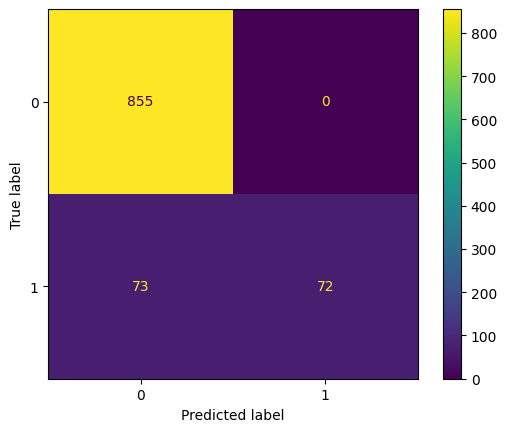

In [31]:
# Mostrar a matriz de confusao
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [32]:
# Calcular log_loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.2337


### Treinar Modelo com Validação Cruzada e Tuning de Hiperparâmetros

In [33]:
# Criar um dicionario com os valores dos hiperparametros a serem testados
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [34]:
# Configurar o GridSearchCV com 5 folds (com StratifiedKFold) e usando Recall como metrica de valicadao
rf_model_cv = RandomForestClassifier(class_weight='balanced', max_features='sqrt', random_state=51)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
grid_search = GridSearchCV(rf_model_cv, param_grid=param_grid, cv=kfolds, scoring='recall', verbose=2)

In [35]:
# Treinar o modelo usando cross-validation para buscar melhores hiperparametros
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_de

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=51, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=51),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='recall', verbose=2)

Usando Cross Validation, dividimos o dataset em:

**X_train (50%)** → `cross_validate` (4 folds treino + 1 val)  
**X_test (50%)** → usado para avaliação final do melhor modelo

### Análise de Resultado - GridSearchCV

In [36]:
# Retornar o melhor modelo
best_model = grid_search.best_estimator_

In [37]:
# Retornar os melhores hiperparametros
best_params = grid_search.best_params_

In [38]:
# Apresentar os melhores hiperparametros
best_params

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 200}

In [39]:
# Retornar a melhor métrica
best_score = grid_search.best_score_

In [40]:
# Apresentar a melhor métrica
best_score

np.float64(0.7027093596059113)

In [41]:
# Fazer predicoes (classificacoes - 0 ou 1)
y_pred = best_model.predict(X_test)

In [42]:
# Mostrar y_pred
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [43]:
# Retornar as probabilidades das previsoes
y_pred_proba = best_model.predict_proba(X_test)

In [44]:
# Mostrar probabilidades
y_pred_proba

array([[0.92689542, 0.07310458],
       [0.91865034, 0.08134966],
       [0.81357313, 0.18642687],
       ...,
       [0.87423978, 0.12576022],
       [0.21831366, 0.78168634],
       [0.32309355, 0.67690645]])

In [45]:
# Avaliacao do modelo
print('Relatório de Classificação')
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       855
           1       0.99      0.70      0.82       145

    accuracy                           0.95      1000
   macro avg       0.97      0.85      0.90      1000
weighted avg       0.96      0.95      0.95      1000



In [46]:
# Retornar os valores da curva ROC - TPR vs. FPR e Threshold (Pontos de Corte)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [47]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [48]:
# Plotar a Curva ROC com o valor do AUC
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor='x', scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

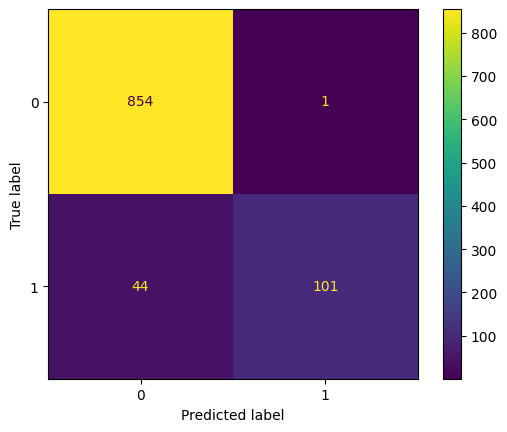

In [49]:
# Mostrar a matriz de confusao
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [50]:
# Calcular log_loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.2708


### Ajustar Threshold

In [51]:
# Criar uma lista de thresholds para testar
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Lista para armazenar metrica
recalls = []

# Calcular as metricas para cada threshold
for threshold in thresholds:
    # Fazer predicoes com o threshold
    y_pred_threshold = (y_pred_proba[:, 1] >= threshold).astype(int)

    # Calcular metrica
    recall = recall_score(y_test, y_pred_threshold)

    # Inserir metrica na lista
    recalls.append(recall)

In [52]:
# Criar Dataframe com os resultados
df_thresholds = pd.DataFrame({'Threshold': thresholds, 'Recall': recalls})

In [53]:
df_thresholds.head(10)

,Threshold,Recall
0,0.3,0.862069
1,0.4,0.806897
2,0.5,0.696552
3,0.6,0.496552
4,0.7,0.324138


In [57]:
# Encontrar o threshold com melhor recall
melhor_threshold = df_thresholds.loc[df_thresholds['Recall'].idxmax()]

print(f"Maior Threshold: {melhor_threshold['Threshold']:.2f}")
print(f"Maior Recall: {melhor_threshold['Recall']:.4f}")

Maior Threshold: 0.30
Maior Recall: 0.8621


In [58]:
# Plotar um gráfico com Threshold
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=thresholds, 
    y=recalls, 
    name='Recall', 
    line=dict(color='blue')
))

fig.update_layout(
    title='Recall por Threshold',
    xaxis_title='Threshold',
    yaxis_title='Recall Score',
    width=800,
    height=500
)

fig.show()

### Análise de Métricas com Threshold

In [60]:
# Fazer predições
y_pred = (y_pred_proba[:, 1] >= melhor_threshold['Threshold']).astype(int)

In [61]:
# Avaliação do Modelo
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       855
           1       0.64      0.86      0.73       145

    accuracy                           0.91      1000
   macro avg       0.81      0.89      0.84      1000
weighted avg       0.93      0.91      0.91      1000



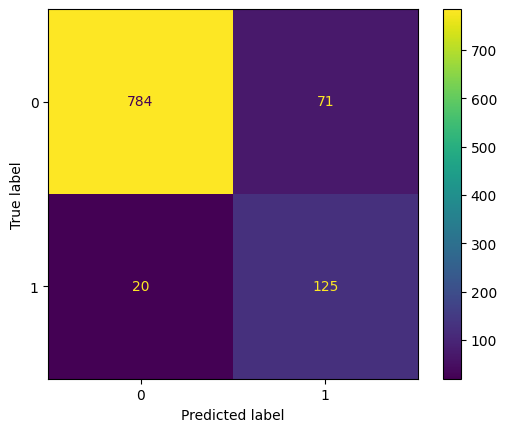

In [62]:
# Mostrar a matriz de confusao
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

### Interpretabilidade

In [63]:
# Importância das variáveis

# Obter a importância das variáveis
importancias = best_model.feature_importances_
nomes_features = preprocessor.get_feature_names_out()

# Criar um DataFrame com as importâncias e nomes das features
df_importancias = pd.DataFrame({'feature': nomes_features, 'importancia': importancias})

# Ordenar o DataFrame por importância (decrescente)
df_importancias = df_importancias.sort_values('importancia', ascending=False).reset_index(drop=True)

In [64]:
# Criar um gráfico com as importâncias
fig = px.bar(
    df_importancias.head(10),  # 10 features mais importantes
    x='importancia',
    y='feature',
    orientation='h',
    title='Importância das 10 principais features',
    labels={'importancia': 'Importância', 'feature': 'Feature'},
    color='importancia',
    color_continuous_scale='Viridis'
)

# Personalizar o layout
fig.update_layout(
    height=600,
    yaxis={'categoryorder': 'total ascending'}
)

fig.show()

In [66]:
# Visualizar as árvores da Random Forest

# Função para visualizar árvore
def visualizar_arvore(modelo, indice_arvore, max_profundidade=5):
    plt.figure(figsize=(20, 10))
    plot_tree(
        modelo.estimators_[indice_arvore],
        feature_names=nomes_features,
        class_names=['0', '1'],
        filled=True,
        rounded=True,
        max_depth=max_profundidade,
        fontsize=9,
        proportion=True,
        precision=2
    )
    plt.title(f'Árvore {indice_arvore} da Random Forest', fontsize=14)
    plt.tight_layout()
    plt.show()

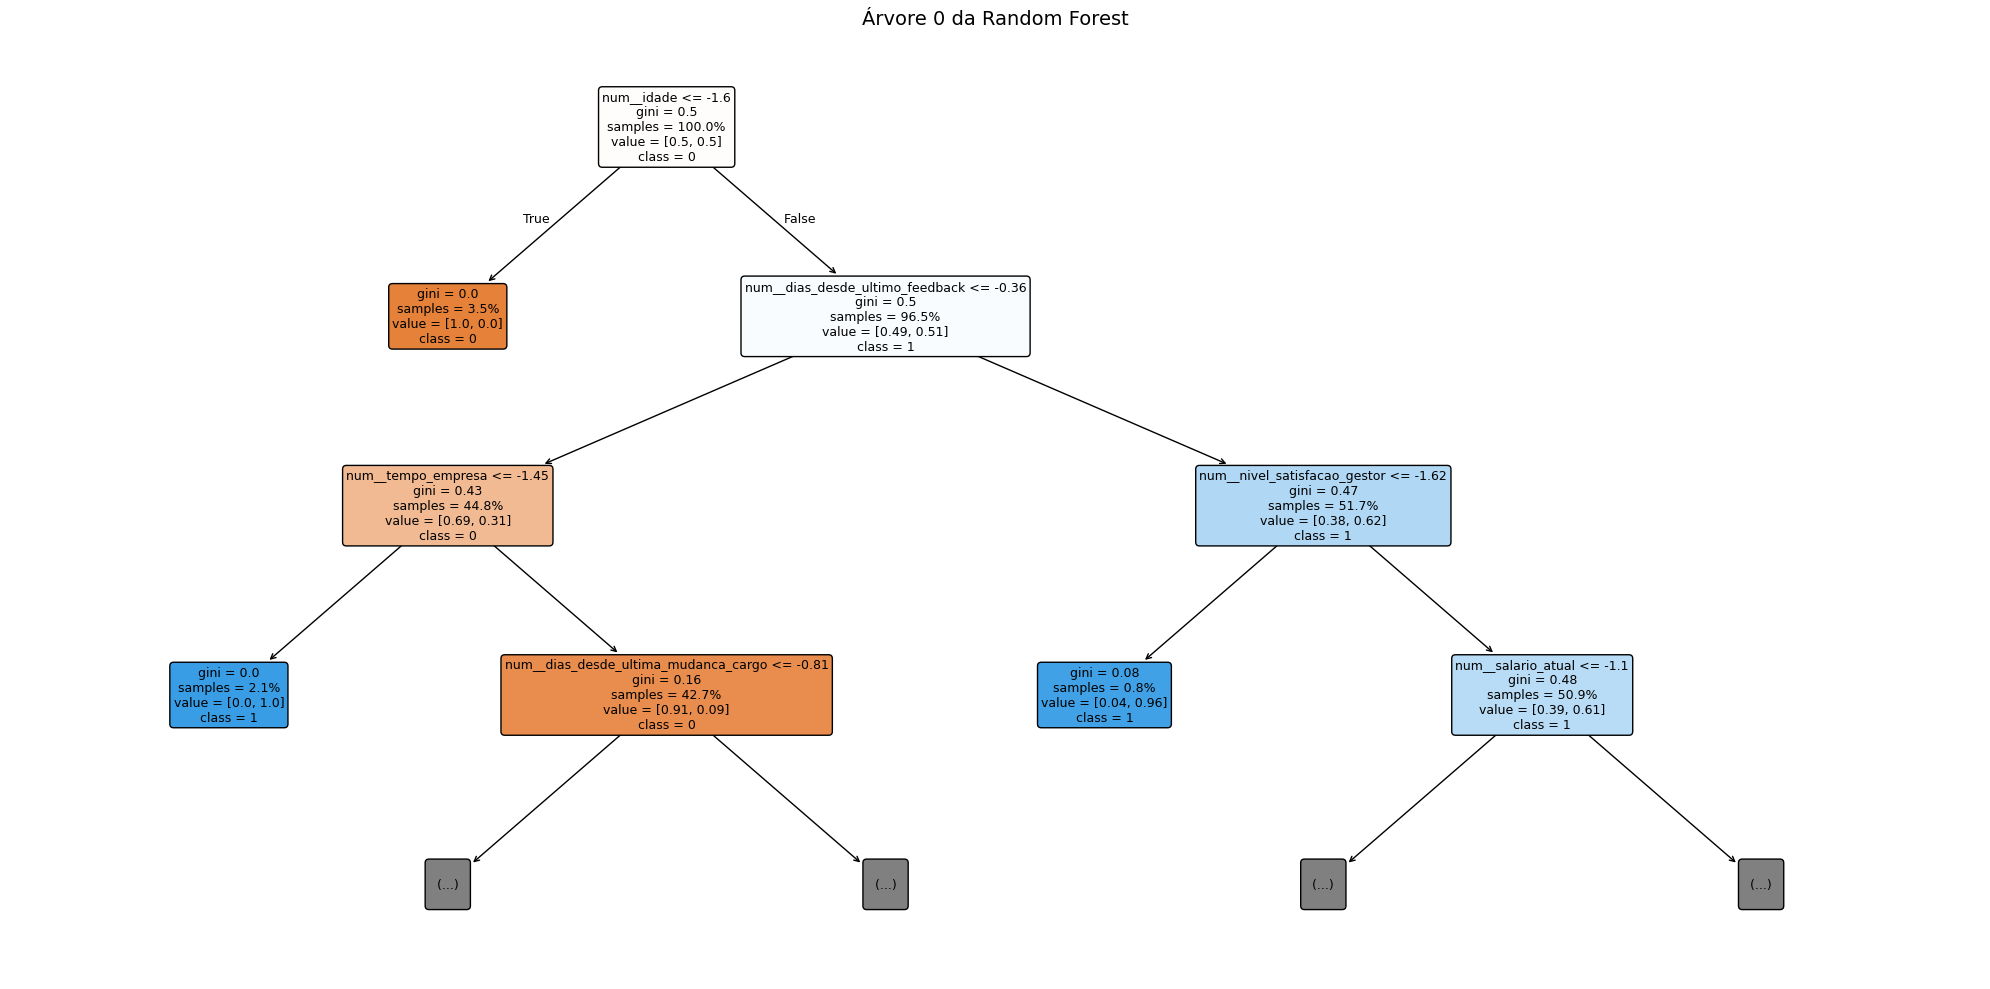

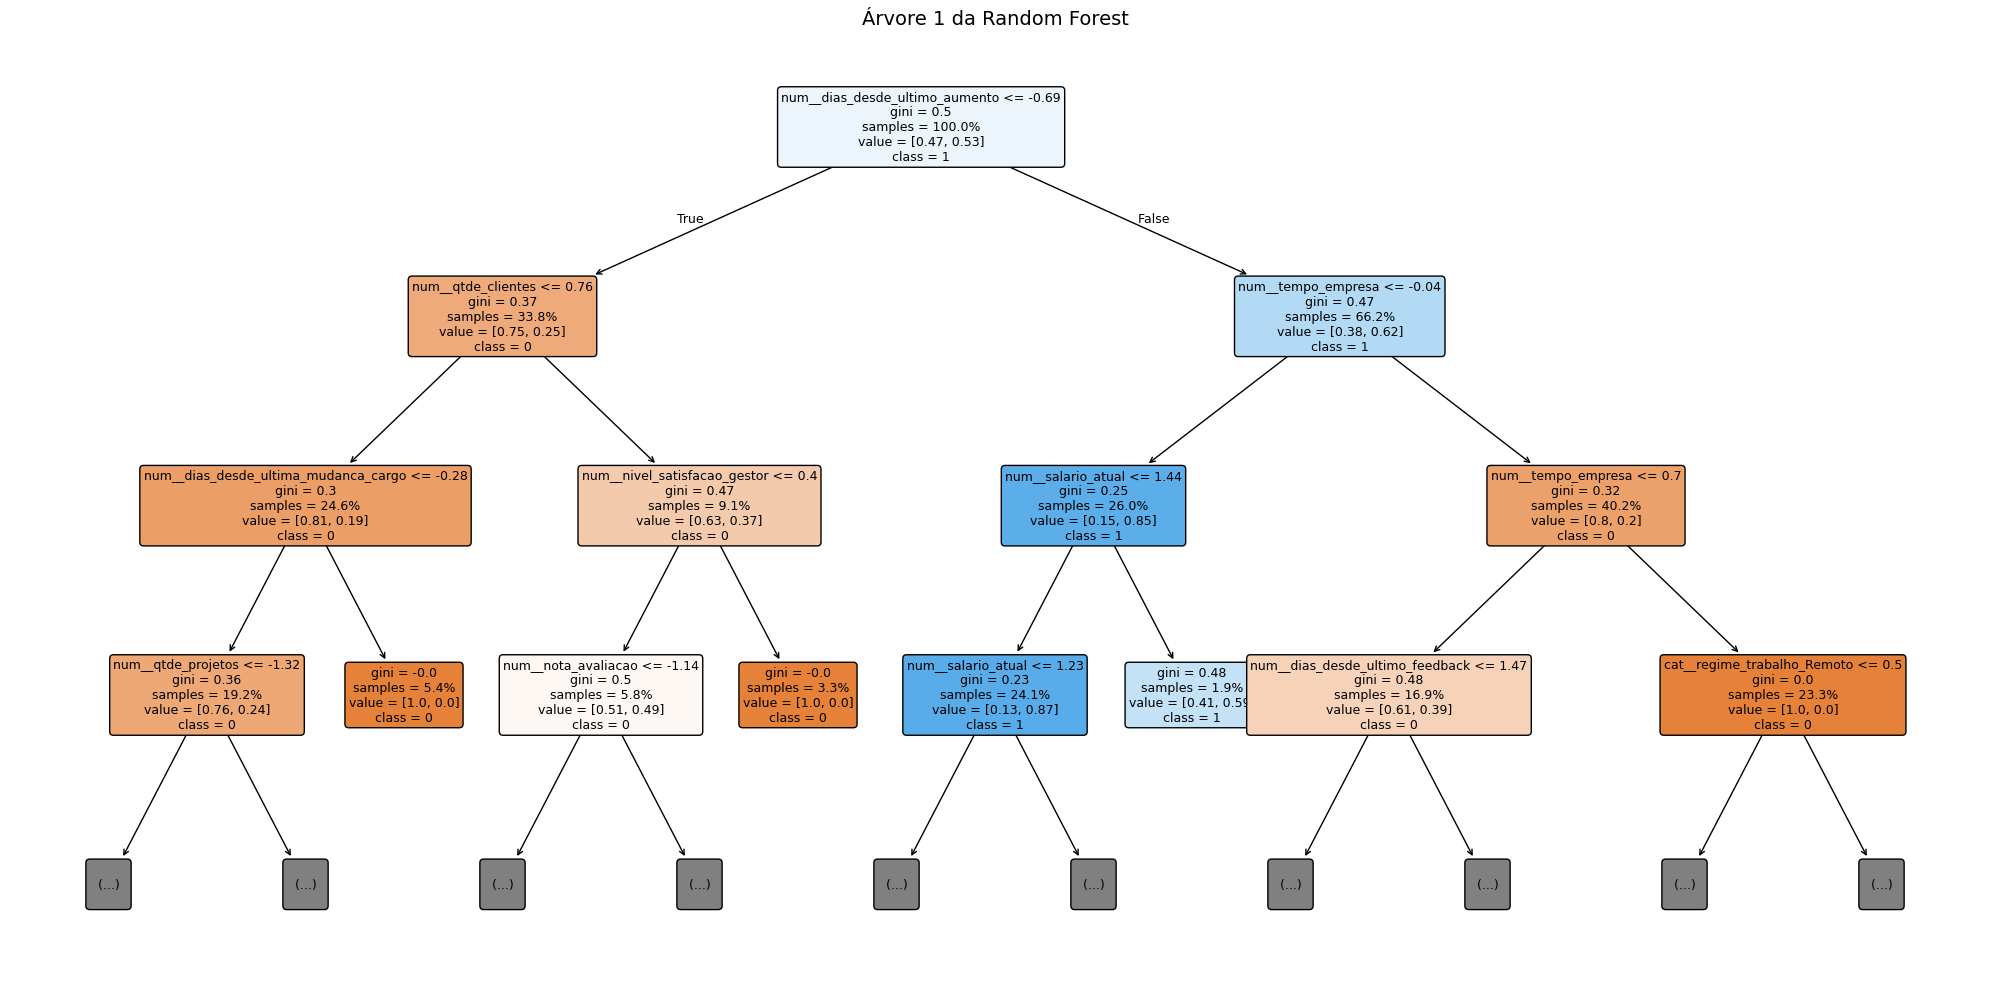

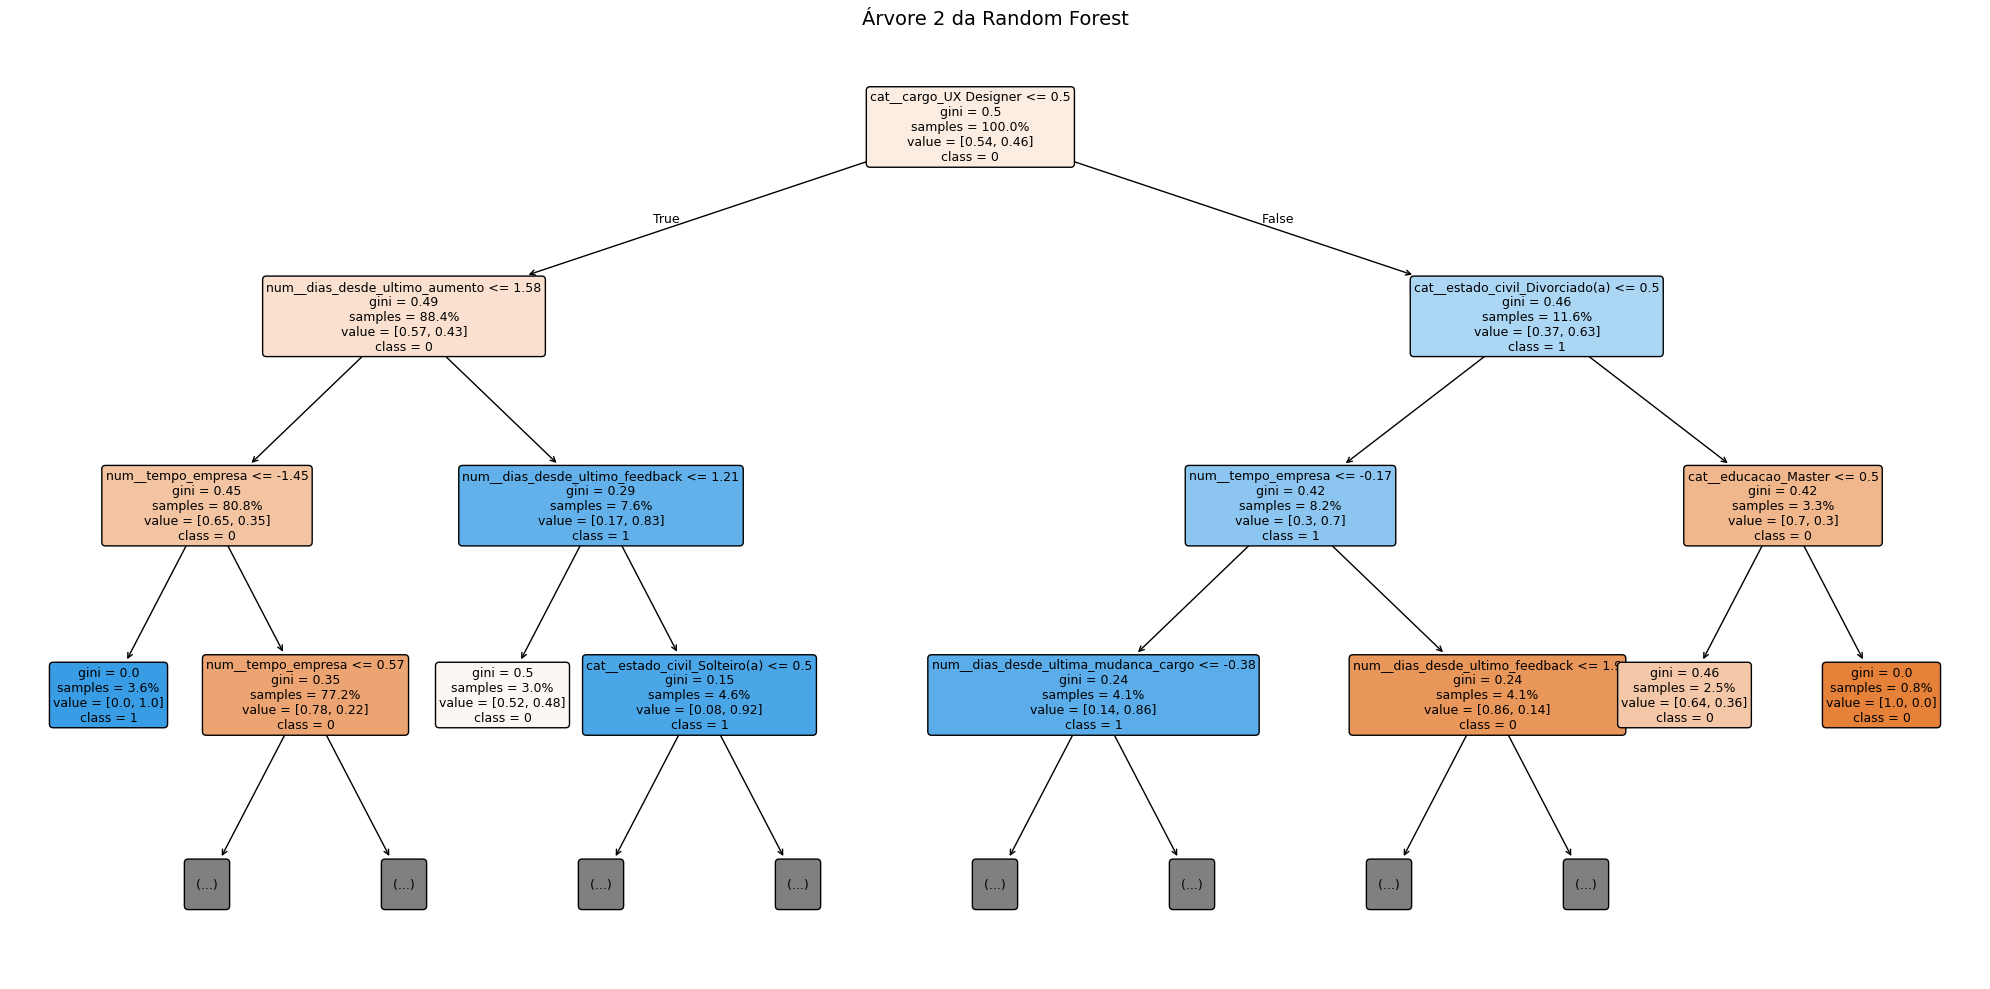

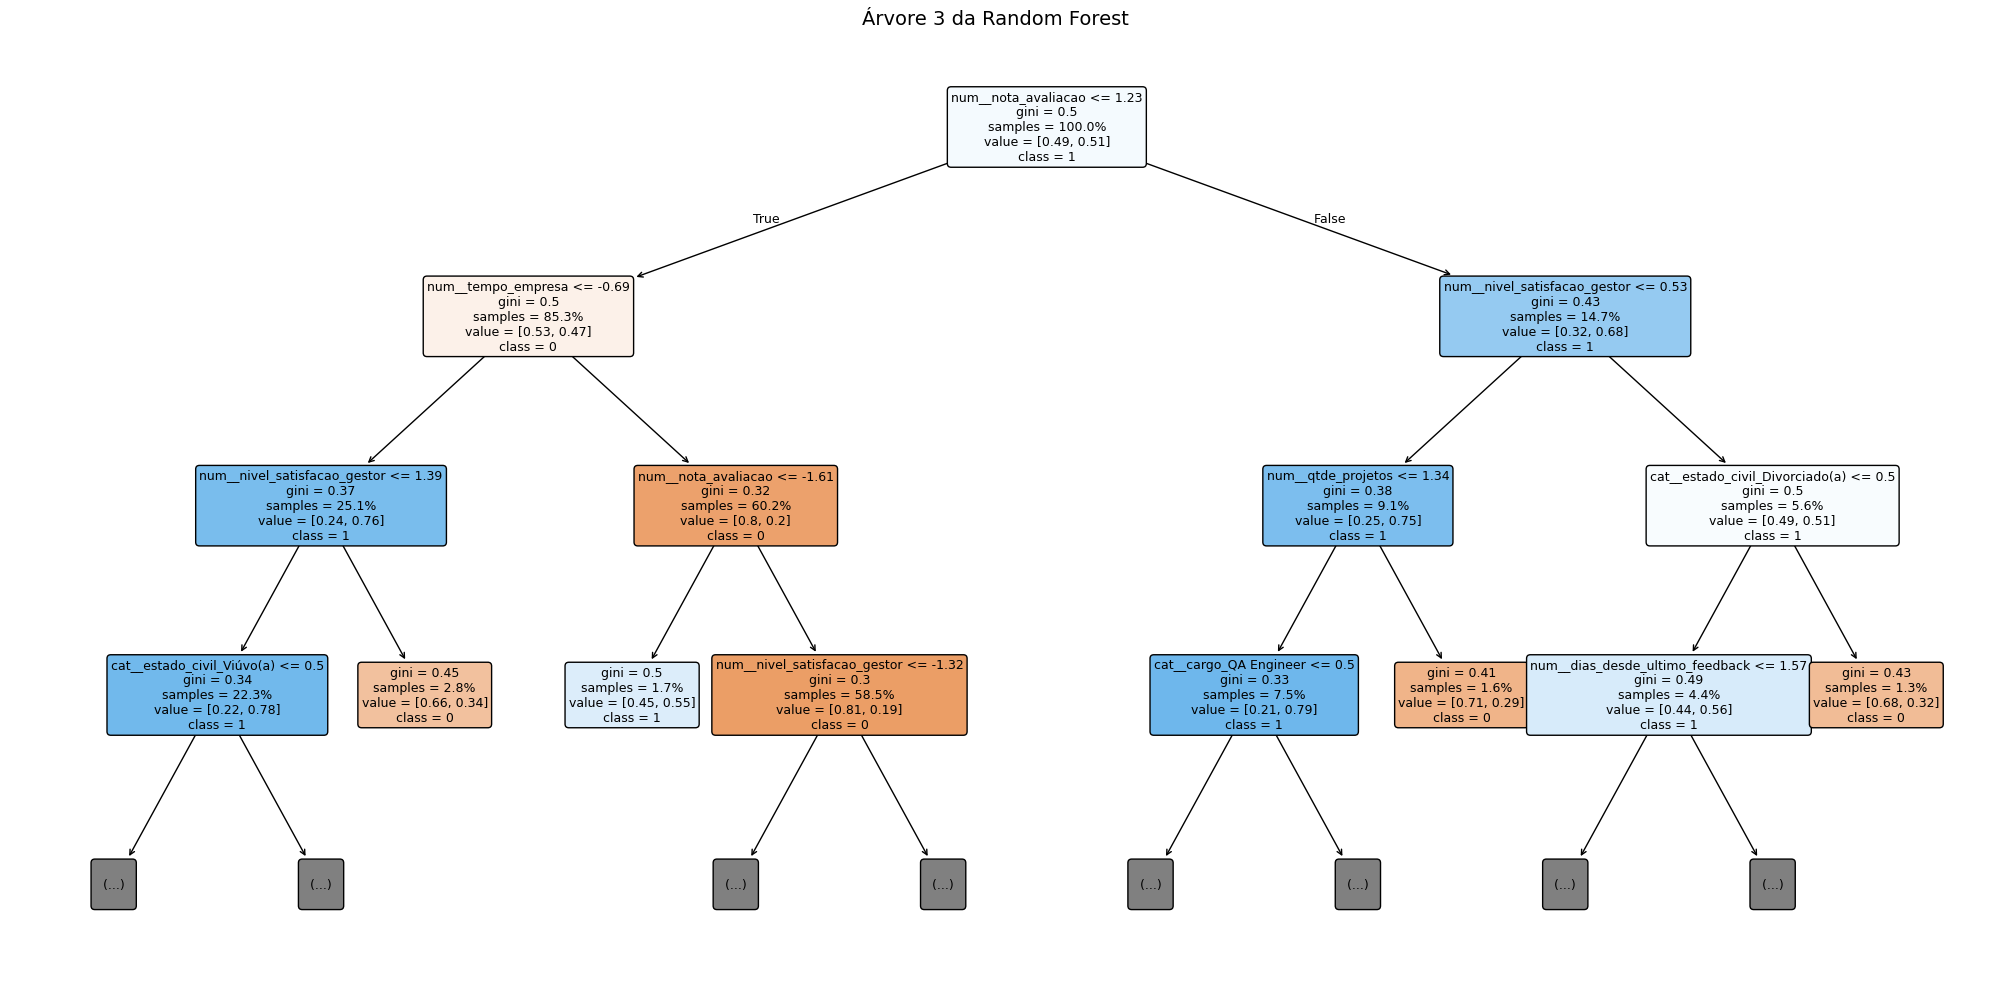

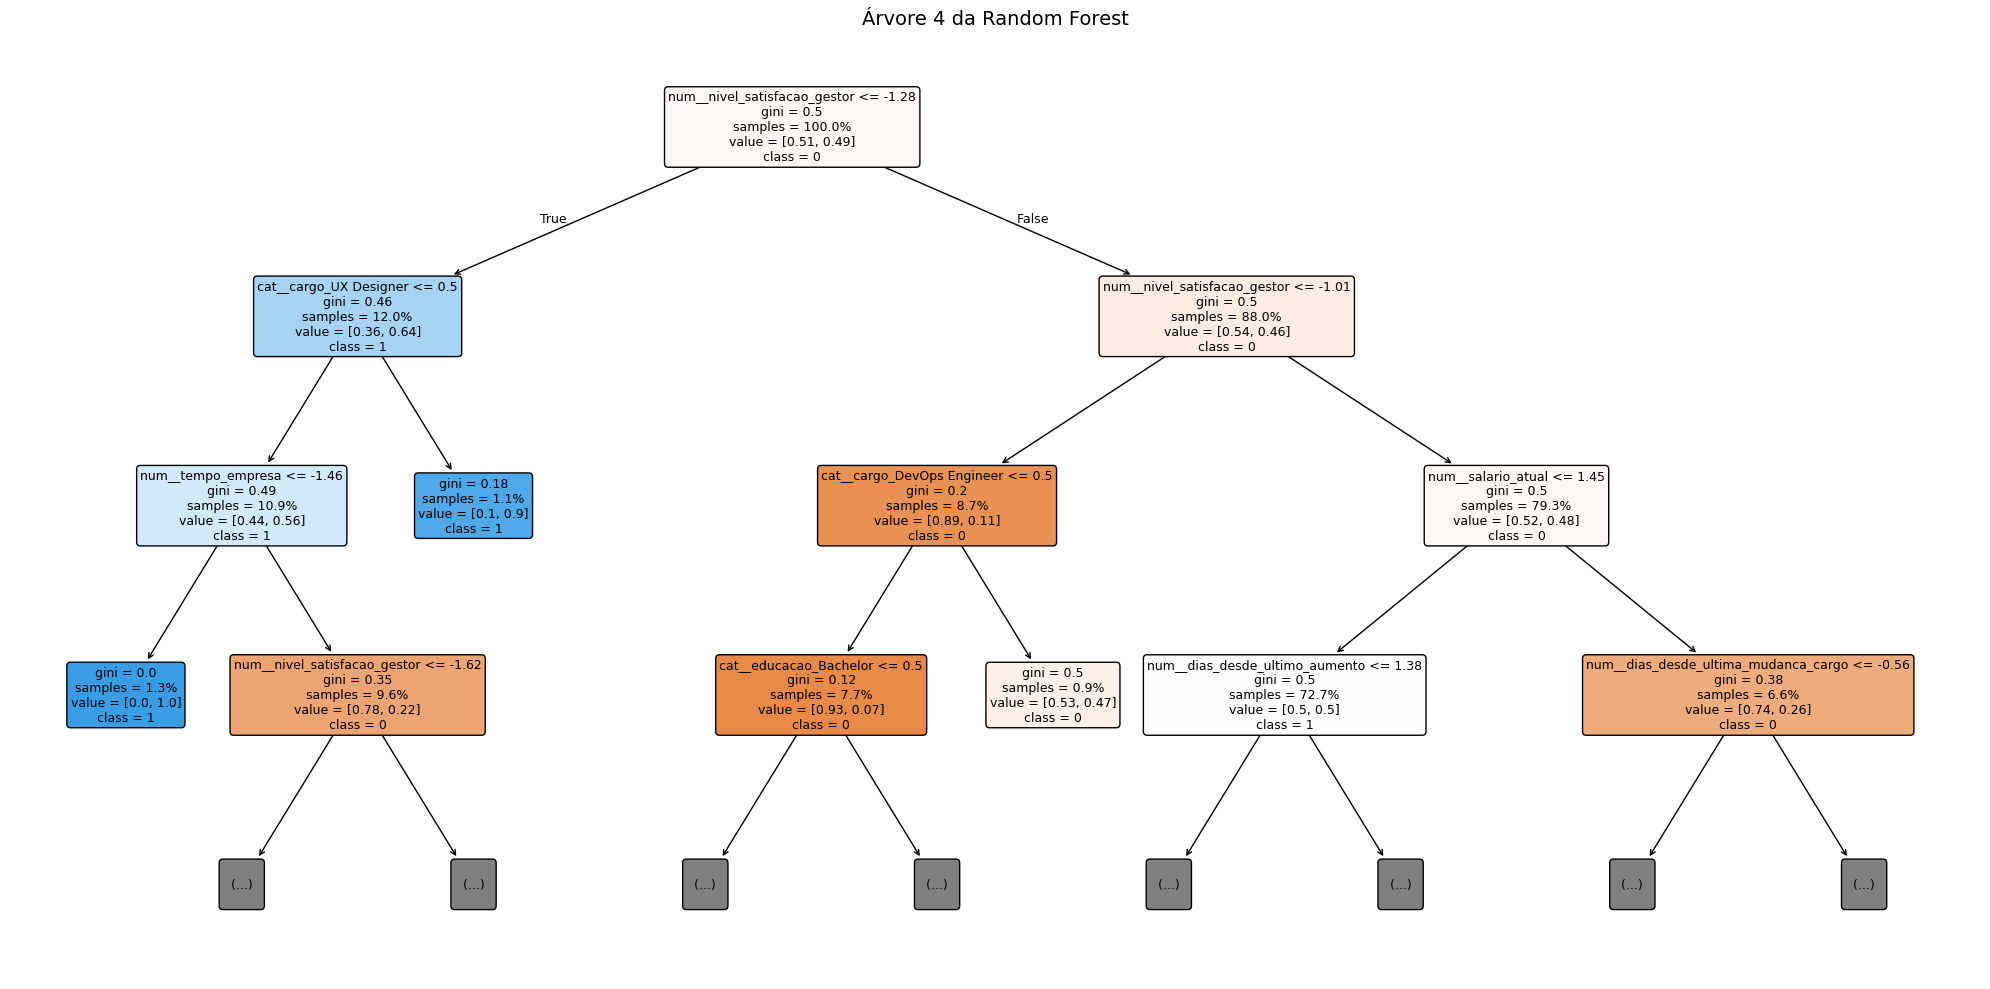

In [67]:
# Visualizar as 5 primeiras árvores
for i in range(5):
    visualizar_arvore(best_model, i, 3)

### Apresentar Plots Shapley Values

In [70]:
# Rodar o explainer no conjunto de treinamento
explainer_class = shap.Explainer(best_model.predict, X_train, feature_names=nomes_features)

In [71]:
# Calcular Shapley Values no conjunto de testes
shap_values_class = explainer_class(X_test)

PermutationExplainer explainer: 1001it [04:41,  3.50it/s]                          


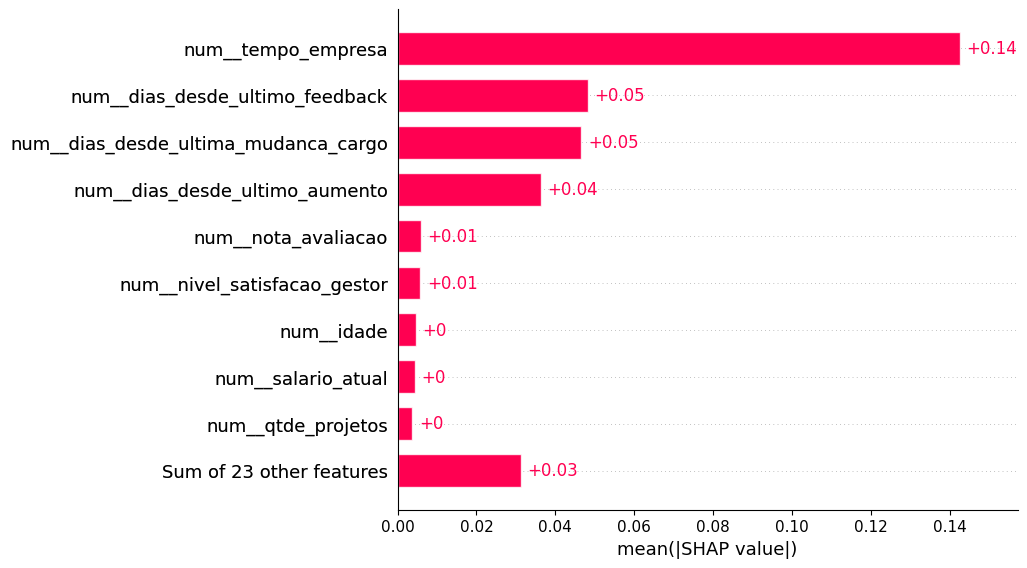

In [73]:
# Plotar a contribuição global por Shapley Values
shap.plots.bar(shap_values_class)

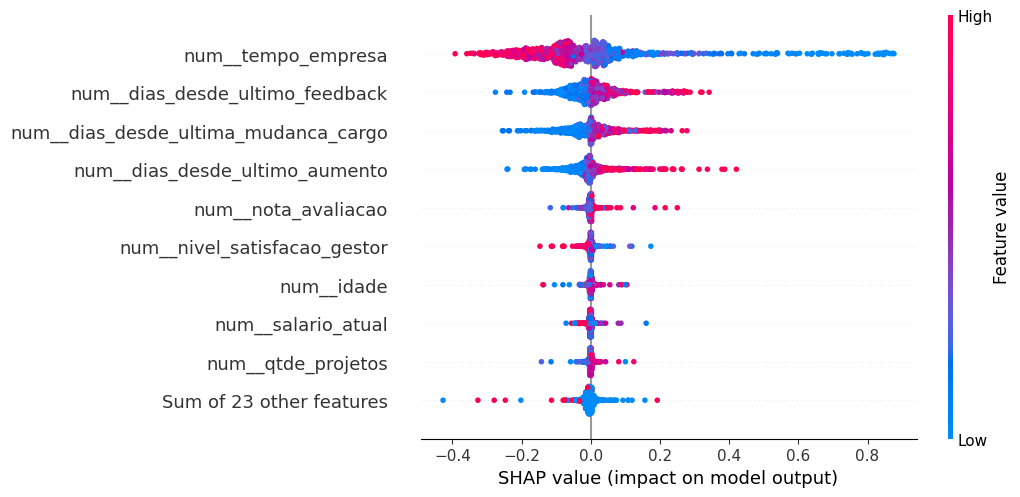

In [74]:
# Plot de Beeswarm Global
shap.plots.beeswarm(shap_values_class, max_display=10)

In [75]:
# Criar um DataFrame contendo y_test e y_pred
df_comparacao = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

In [76]:
# Criar um DataFrame contendo y_test e y_pred
df_comparacao = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

In [77]:
# Mostrar Dataframe
df_comparacao

,y_test,y_pred
1617,0,0
885,0,0
433,0,0
188,0,0
1264,0,0
...,...,...
784,0,0
1914,0,0
227,1,0
316,1,1


In [78]:
# Valor Real (227)
y_test[227]

np.int64(1)

In [79]:
# Valor Predito (227)
y_pred[227]

np.int64(0)

In [80]:
# Mostrar os dados do indice (227)
X_test[227]

array([-0.50087032,  1.66458541, -0.10520997,  0.77154649,  0.01045753,
       -0.49864509,  0.09856869,  0.74134107, -0.92650459, -1.15716535,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [81]:
def inverse_transform_manual(X_transformed, preprocessor, feature_names):
    # Armazenar nomes originais das features
    feature_names_original = feature_names

    # Criar um DataFrame com os dados transformados
    df_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

    # Criar um DataFrame vazio para receber os dados originais
    df_original = pd.DataFrame(columns=feature_names_original)

    # Loop em cada transformador
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            # Para features numéricas, usar o inverse_transform
            df_original[features] = transformer.inverse_transform(
                df_transformed[[f'{name}__{f}' for f in features]]
            )
        elif name == 'cat':
            # Para features categóricas, precisamos identificar as colunas e qual delas tem o valor 1
            for feature in features:
                cols = [col for col in df_transformed.columns if col.startswith(f'{name}__{feature}')]
                for col in cols:
                    if df_transformed[col].iloc[0] == 1:
                        df_original[feature] = col.split('__')[-1]
                        break

    return df_original

In [82]:
# Trazer dados originais do index 227
inverse_transform_manual(X_test[[227]], preprocessor, X.columns)

,idade,genero,estado_civil,educacao,regime_trabalho,cargo,salario_atual,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
0,33.0,genero_Outro,estado_civil_Viúvo(a),educacao_PhD,regime_trabalho_Presencial,cargo_Product Manager,24347.0,7.9,NaN,7.0,4.0,4.1,1088.0,984.0,335.0,239.0


In [83]:
# Probabilidade do index 227
y_pred_proba[227]

array([0.89741484, 0.10258516])

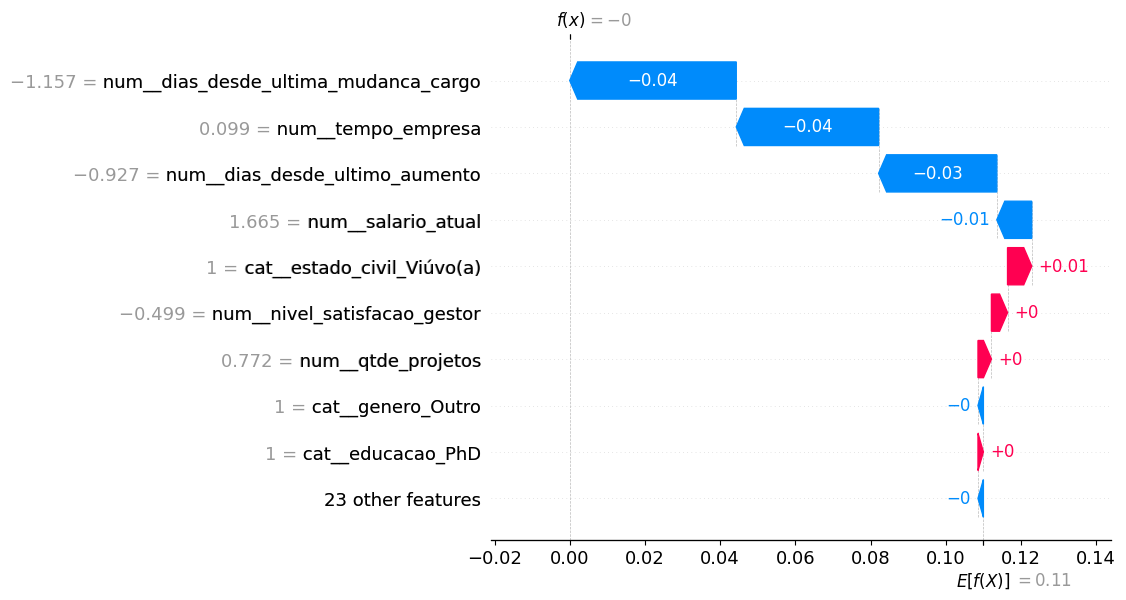

In [84]:
# Plotar os Shap Values para um exemplo específico
shap.plots.waterfall(shap_values_class[227], max_display=10)